In [2]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAETest import SeqVAETest
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import numpy as np

#pd.set_option("display.max_rows", None)

This notebook can be used to test new features for a model without having to use the WandB service

# Config

In [4]:
config = {
        # Dataset info
        "dataset": "playground",
        "seq_theta": 0.2, # reweighting 
        "AA_count": 21, # standard AA + gap
        
        # ADAM 
        "learning_rate": 1e-5, # ADAM
        "weight_decay": 0.01, # ADAM

        # Hidden units 
        "momentum": 0.1, 
        "dropout": 0.5,

        # Training loop 
        "epochs": 100,
        "batch_size": 128,
        "max_norm": 1.0, # gradient clipping
        
        # Model info
        "architecture": "SeqVAETest",
        "latent_dims": 3,
        "hidden_dims": [32, 16],
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Read in data

In [45]:
from pathlib import Path
DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp_alns/independent_runs/no_synthetic/alns/"
filepath = DATA_PATH + 'GFP_AEQVI_full_04-29-2022_b08_extants_no_syn.aln'
aln = st.read_aln_file(filepath)
aln.head()

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gfp_alns/independent_runs/no_synthetic/alns/GFP_AEQVI_full_04-29-2022_b08_extants_no_syn.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Performing one hot encoding
Number of seqs: 360


,id,sequence,encoding
0,GFP_AEQVI/1-238,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,UniRef100_UPI0011C34247/2-231,VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,UniRef100_UPI0011C34247/384-556,VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKL...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,UniRef100_UPI0011C3426C/2-231,VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,UniRef100_UPI0011C3426C/384-556,VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKL...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [41]:
msa, _, _ = st.convert_msa_numpy_array(aln)

Sequence weight numpy array created with shape (num_seqs, columns):  (360, 238)


In [42]:
msa.shape

(360, 238)

In [46]:
from evoVAE.utils.seq_tools import encode_and_weight_seqs

code, weight = encode_and_weight_seqs(aln, 0.2)
aln['weight'] = weight
aln = aln[:]
aln

Encoding the sequences and calculating weights
The sequence encoding has size: (360,)

Sequence weight numpy array created with shape (num_seqs, columns):  (360, 238)
The sequence weight array has size: (360,)



,id,sequence,encoding,weight
0,GFP_AEQVI/1-238,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.003484
1,UniRef100_UPI0011C34247/2-231,VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.003690
2,UniRef100_UPI0011C34247/384-556,VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKL...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.062500
3,UniRef100_UPI0011C3426C/2-231,VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.003690
4,UniRef100_UPI0011C3426C/384-556,VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKL...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.062500
...,...,...,...,...
355,UniRef100_Q6RYS5/2-223,----AEYFEKPLPYKVELEGDVDGQKFTVIGEGQGDASTGRVEGKY...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
356,UniRef100_Q6RYS6/40-259,-----ETFQKKLPYKLELDGDVDGQTFKVIGEGVGDATTGVIEGKY...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
357,UniRef100_J9PIH6/6-230,MNVGAMLFNKELPFVCELDGEINGHKFSVRGKGIGNSAQGLTHGIH...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.000000
358,UniRef100_A0A7M5TYI8/7-231,-NVGALIFNKELPFVVEVDCDIDDHKFSIRGKGVGNAEKGLMVGKY...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.500000


In [69]:

# train, val = train_test_split(aln, test_size=0.2)

# # TRAINING
# train_dataset = MSA_Dataset(
#     train["encoding"], train['weight'], train["id"]
# )

# # VALIDATION
# val_dataset = MSA_Dataset(
#     val["encoding"], val['weight'], val["id"]
# )

# # DATA LOADERS #
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

# print(len(train_loader), len(val_loader))
# #next(iter(train_loader))[0].shape

1 1


# Build model

In [107]:
# get the sequence length 
from torch import Tensor
from evoVAE.models.seqVAE import SeqVAE
import evoVAE.utils.statistics as stats
import matplotlib.pyplot as plt

dataset = MSA_Dataset(
    aln["encoding"], aln['weight'], aln["id"]
)

# DATA LOADERS #
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)


SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * config['AA_count']

seq_len, input_dims

# use preset structure for hidden dimensions 
model = SeqVAETest(input_dims=input_dims, latent_dims=config['latent_dims'], hidden_dims=config['hidden_dims'], config=config) 


def sample_latent_space(model: SeqVAE, data_loader: MSA_Dataset, num_samples: int) -> Tuple[List[str], List[Tensor]]:
    """
    Take a trained model and sample the latent space num_samples many times. This gets the average 
    latent space representation of that sequence. 

    Returns:
    ids: The ID of each sequence.
    x_hats: The model output for each sequence. 
    """
    
    ids = []
    x_hats = []
    for encoding, _, id in data_loader:

        # get into flat format to pass through the model 
        encoding = encoding.float()
        encoding = torch.flatten(encoding, start_dim=1)

        # get encoding and replicate to allow multiple samples from latent space 
        z_mu, z_logvar = model.encode(encoding)    
        z_mu = z_mu.expand(num_samples, z_mu.shape[0], z_mu.shape[1])
        z_logvar = z_logvar.expand(num_samples, z_logvar.shape[0], z_logvar.shape[1])
        
        # pass each sample through the latent space and then average and decode
        z_samples = model.reparameterise(z_mu, z_logvar)
        mean_z = torch.mean(z_samples, dim=0)
        x_hat = model.decode(mean_z)

        ids.extend(id)
        x_hats.extend(x_hat.detach())
        

    return ids, x_hats

def translate_model_predictions(x_hats: List[Tensor]) -> List[str]:
    """
    Get the most likely residue for each column in the model reconstruction. 

    Returns (List[str]):
    The string representation of each sequence. 
    """
    
    reconstructions = []
    for x_hat in x_hats:
    
        # decode the Z sample and get it into a PPM shape
        x_hat = x_hat.unsqueeze(-1)
        # print(x_hat.shape)
        x_hat = x_hat.view(orig_shape)

        # Identify most likely residue at each column 
        indices = x_hat.max(dim=-1).indices.tolist()
        recon = "".join([st.GAPPY_PROTEIN_ALPHABET[x] for x in indices])
        reconstructions.append(recon)

    return reconstructions


def calc_covariances(ids: List[str], reconstructions: List[Tensor], aln: pd.DataFrame, outfile: str) -> Tuple[np.ndarray, np.ndarray]:

    # recons_df = pd.DataFrame({"id": ids, "sequence": reconstructions})
    # recon_msa, _, _ = st.convert_msa_numpy_array(recons_df)
    # predicted_covar = stats.pair_wise_covariances(recon_msa)

    # # save reconstruction vs actual for visualisation with MSA later
    # recons_df["sequence"] = aln["sequence"] 
    # recons_df["reconstructions"] = reconstructions
    # recons_df.to_pickle(outfile + "_seqs.pkl")

    msa, _, _ = st.convert_msa_numpy_array(aln)
    actual_covar = stats.pair_wise_covariances(msa)

    return actual_covar, actual_covar


num_samples = 5
outfile = "test"
model.eval()
ids, x_hats = sample_latent_space(model, loader, num_samples)
orig_shape = tuple(aln["encoding"].values[0].shape)
reconstructions = translate_model_predictions(x_hats)
actual_covar, predicted_covar = calc_covariances(ids, reconstructions, aln, outfile)


Sequence weight numpy array created with shape (num_seqs, columns):  (4, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (4, 238)


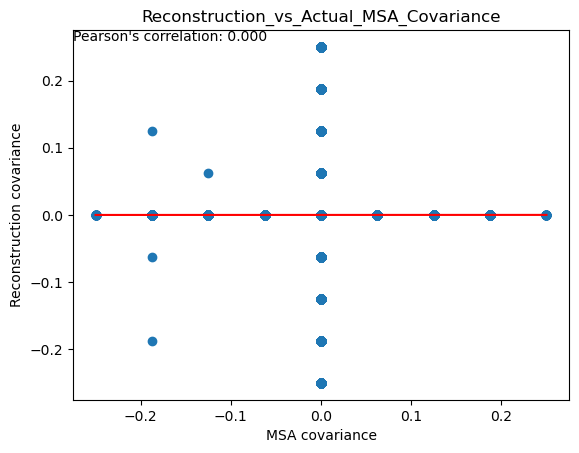

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.scatter(actual_covar, predicted_covar)
plt.xlabel("MSA covariance")
plt.ylabel("Reconstruction covariance")
slope, intercept = np.polyfit(actual_covar, predicted_covar, deg=1)
x = np.arange(min([actual_covar.min(), predicted_covar.min()]), max([actual_covar.max(), predicted_covar.max()]) + 0.1, 0.1)
regression_line = slope * x + intercept

# Calculate correlation coefficient, use [0,1] to not take from diagnonal 
correlation_coefficient = np.corrcoef(actual_covar, predicted_covar)[
    0, 1
]

# Display correlation value
plt.text(
    plt.xlim()[0],
    plt.ylim()[1],
    f"Pearson's correlation: {correlation_coefficient:.3f}",
    va="top",
)

plt.title("Reconstruction_vs_Actual_MSA_Covariance")
plt.plot(x, regression_line, color="red")

filename = outfile + "_covar.png"
plt.savefig(filename)


#print(ids, x_hats)

In [ ]:
# very small nummy data 
dummy = next(iter(train_loader))[0].float()
print(dummy.shape)
# reconstruct input, note it has been flattened 
log_p, z_sample, z_mu, z_logvar = model(dummy)

# grab the shape of the input for reshaping
orig_shape = log_p.shape[0:-1]

# add on extra dim, then make it one-hot encoding shape (obs, seq_len, AA_count)
log_p = torch.unsqueeze(log_p, -1)
log_p = log_p.view(orig_shape + (-1, config['AA_count']))

In [ ]:
mut_data = pd.read_csv('../data/dms_data/GFP_AEQVI_Sarkisyan_2016.csv')
subset = mut_data.copy()[0:10]

In [ ]:
encoding, _ = st.encode_and_weight_seqs(mut_data['mutated_sequence'], 0.2, reweight=False)
mut_data['encoding'] = encoding
mut_data[0:10]

In [ ]:
mut_data.to_pickle("GFP_AEQVI_Sarkisyan_2016_dms_encoded.pkl")

In [ ]:
encoding, weights = st.encode_and_weight_seqs(subset['mutated_sequence'], 0.2, reweight=True)
subset['encoding'] = encoding
subset['weights'] = weights
subset

In [ ]:
metadata = pd.read_csv("../data/dms_data/DMS_substitutions.csv")
metadata = metadata[metadata["DMS_id"].str.contains("GFP")]
metadata


In [ ]:

import sklearn
import sklearn.preprocessing


wild_type = metadata['target_seq'].to_numpy()[0]
wild_one_hot = torch.Tensor(st.seq_to_one_hot(wild_type)).unsqueeze(0)

model.eval()
wild_model_encoding, _, _, _ = model(wild_one_hot)

orig_shape = wild_model_encoding.shape[0:-1]

wild_model_encoding = torch.unsqueeze(wild_model_encoding, -1)

wild_model_encoding = wild_model_encoding.view(orig_shape + (-1, model.AA_COUNT))


# get the wild type encoding 
wild_model_encoding = wild_model_encoding.squeeze(0)

one_hot = wild_one_hot.squeeze(0)
wt_prob = mt.seq_log_probability(one_hot, wild_model_encoding)

variant_encodings = torch.Tensor(np.stack(subset['encoding'].values))
variant_model_outputs, _, _, _ = model(variant_encodings)

model_scores =[]
for variant, var_one_hot in zip(variant_model_outputs, variant_encodings):
    
    print(variant.shape)
    var_model_encoding = torch.unsqueeze(variant, -1)
    print(var_model_encoding.shape)
    var_model_encoding = var_model_encoding.view(orig_shape + (-1, model.AA_COUNT))
    var_model_encoding = var_model_encoding.squeeze(0)
    log_prob = mt.seq_log_probability(var_one_hot, var_model_encoding)
    
    # make variant fitness relative to the wild type
    model_scores.append(log_prob - wt_prob)
    
model_scores = pd.Series(model_scores)
model_scores, subset['DMS_score']



In [ ]:
a = torch.Tensor([0,0,0])
b = torch.Tensor([1,2,3])
a - b

In [ ]:
spear_rho, k_recall, ndcg, roc_auc = mt.summary_stats(predictions=model_scores, actual=subset['DMS_score'], actual_binned=subset['DMS_score_bin'])
spear_rho, k_recall, ndcg, roc_auc

In [ ]:
import evoVAE.utils.seq_tools as st
from evoVAE.utils.seq_tools import GAPPY_PROTEIN_ALPHABET, calc_position_prob_matrix, calc_mean_seq_embeddings, calc_position_prob_matrix, create_euclidean_dist_matrix, plot_residue_distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

seqs = st.read_aln_file("../data/test.aln")
encode = calc_mean_seq_embeddings(seqs)
ppm = calc_position_prob_matrix(seqs)


create_euclidean_dist_matrix(encode, plot=True)


plot_residue_distributions(encode)
#print(ppm)
#print()
#print(avgs)
